In [50]:
import pandas as pd
import numpy as np
import os

In [51]:
with open("sent_corpus.csv", "r") as sent_file:
    lines = sent_file.read().split("\n")

In [52]:
%time rows = [line.split(",") for line in lines if line]
%time rows = [row[:3] + [",".join(row[3:])] for row in rows]
# remove document start character 
rows[0][0] = rows[0][0][1:]

sentDf_cols = ['ItemID', 'Sentiment', 'SentimentSource', 'SentimentText']


%time sentDf = pd.DataFrame(rows[1:],columns=sentDf_cols)

print(sentDf.columns.values)

sentDf[["ItemID","Sentiment"]] = sentDf[["ItemID","Sentiment"]].astype(int)
%time sentDf["SentimentText"] = sentDf["SentimentText"].apply(lambda text: text.split())

CPU times: user 5.26 s, sys: 5.65 s, total: 10.9 s
Wall time: 13.5 s
CPU times: user 5.42 s, sys: 1.43 s, total: 6.85 s
Wall time: 8.01 s
CPU times: user 419 ms, sys: 96.3 ms, total: 516 ms
Wall time: 696 ms
['ItemID' 'Sentiment' 'SentimentSource' 'SentimentText']
CPU times: user 9.26 s, sys: 1.98 s, total: 11.2 s
Wall time: 12.4 s


In [53]:
## -*- coding: utf-8 -*-

curdir = os.getcwd()
tweet_path = curdir + "/crawler_v1/code/tweettext.txt"
print(tweet_path)

tweets = []
tweet_file = open(tweet_path, "rb")
%time 
for line in tweet_file:
#    print(line)
#    line = line_pre.decode('utf-8')
    tweet = ""
    if(line[:2] == "RT"):
        char_loc = 0
        for char in line:
            char_loc += 1
            if(char==":"):
                break

        tweet = line[-(len(line)-char_loc):]
    else:
        tweet = line
    tweets.append(tweet)

#[tweet.decode('utf-8') for tweet in tweets]
print(tweets)

print("done")

/Users/aduriseti/Documents/2017fall/cs145/project/crawler_v1/code/tweettext.txt
CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 11 µs
['I hate it when someone posts really inspiring art or something and all people comment is \xe2\x80\x9cdeep\xe2\x80\x9d... like... that\xe2\x80\x99s a\xe2\x80\xa6 https://t.co/7pdNLhZaOw\n', 'I hate it when some dumb broad starts whining about men who nut too fast....\n', '"It was a race... You lost, bitch!"\n', 'I hate people on twitter who complain about what girls do, but they are the same people who complain about other pe\xe2\x80\xa6 https://t.co/Jtajyid1Fw\n', ' Haters don\xe2\x80\x99t hate us, they hate themselves. \n', 'Because we are a reflection of what they wish to be.\n', " I fuckin hate it when people call Harry a womanizer yall know how much he hates it he even said he doesn't like to be ca\xe2\x80\xa6\n", ' When people get hurt, they learn to hate.\n', '#ALDUBHeartsNeverApart\n', ' Do the 2016 Hate Crime statistics include the hoax

In [54]:
import gensim
%time w2vM = gensim.models.Word2Vec(sentDf["SentimentText"])
# %time w2vM_google = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

CPU times: user 6min 33s, sys: 8.94 s, total: 6min 42s
Wall time: 3min


In [55]:
# number of samples to aggregate
Ns = int(1e5)

In [56]:
%%time
# MEAN AGGREGATION
tvecs = np.array([np.array([w2vM[t] if t in w2vM
                                else np.zeros((100,))
                            for t in twt]).mean(axis=0)
                 for twt in sentDf["SentimentText"][:Ns]])
# SUM AGGREGATION
# tvecs = np.array([np.array([w2vM[t] if t in w2vM
#                                 else np.zeros((100,))
#                             for t in twt]).sum(axis=0)
#                  for twt in sentDf["SentimentText"][:Ns]])

# print(tvecs[:5])
print("prediction vecs...")

tvecs_predict = np.array([np.array([w2vM[t] if t in w2vM
                                else np.zeros((100,))
                            for t in twt]).mean(axis=0)
                 for twt in tweets[:Ns]])

# print(tvecs_predict[:5])

prediction vecs...
CPU times: user 8.35 s, sys: 214 ms, total: 8.56 s
Wall time: 8.74 s


In [57]:
# number of samples to train on
N = int(1e5)
X = tvecs[:N]
y = sentDf["Sentiment"][:N].values
# inverse classifier
# y = 1 - y

In [58]:
# generate test/train split
ratio = 0.8
tidx = np.random.rand(N) < ratio
pidx = ~tidx

In [59]:
import sklearn
from sklearn import ensemble,svm,neural_network,discriminant_analysis
from sklearn.metrics import roc_curve,auc,precision_recall_curve

from matplotlib import pyplot as plt
% matplotlib inline

In [60]:
def roc_auc(clf,X,y):
    probs = clf.predict_proba(X[pidx])
    fpr, tpr, thresholds = roc_curve(y[pidx], probs[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_str = 'ROC (AUC Gain = %0.2f)' % (roc_auc - 0.5)
    plt.plot(fpr, tpr, lw=1,label=roc_str)
    plt.plot([0,1],[0,1],label="RAN CLF")
    plt.title(roc_str)
    plt.show()

In [61]:
def prrc_auc(clf,X,y):
    probs = clf.predict_proba(X)
    pr, rc, thresholds = precision_recall_curve(y, probs[:, 1])
    roc_auc = auc(rc, pr)
    roc_str = 'Prec vs Recall (AUC Gain = %0.2f)' % (roc_auc - np.mean(y))
    plt.plot(rc,pr, lw=1,label=roc_str)
    plt.plot([0,1],[np.mean(y),np.mean(y)],label="RAN CLF")
    plt.axis([0,1,0,1])
    plt.title(roc_str)
    plt.show()

In [62]:
def evaluate(clf,X,y):
    yhat = clf.predict(X)
    accu = np.mean(yhat == y)
    prec = np.mean(y[yhat == 1])
    recl = np.mean(yhat[y == 1])
    f1 = 2 * prec * recl / (prec + recl)
    print("Accuracy",accu,"Precision",prec,"Recall",recl,"F1",f1)

CPU times: user 5.38 s, sys: 104 ms, total: 5.49 s
Wall time: 5.57 s
TEST
('Accuracy', 0.67323630483121089, 'Precision', 0.66791018007030634, 'Recall', 0.83520229658204004, 'F1', 0.74224667145021139)
CPU times: user 52 ms, sys: 23.7 ms, total: 75.7 ms
Wall time: 78.3 ms
TRAIN
('Accuracy', 0.67907545005734804, 'Precision', 0.67432001567481881, 'Recall', 0.83541873551804036, 'F1', 0.7462742469642013)
CPU times: user 151 ms, sys: 47.3 ms, total: 198 ms
Wall time: 205 ms
ROC AUC


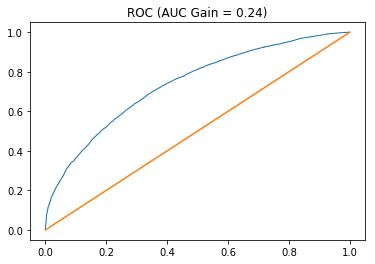

CPU times: user 285 ms, sys: 55.3 ms, total: 341 ms
Wall time: 349 ms
PRECISION/RECALL AUC


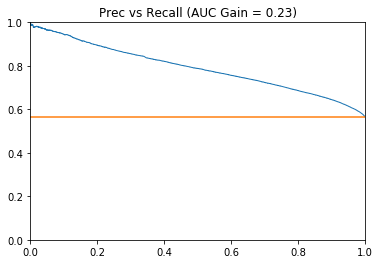

CPU times: user 409 ms, sys: 54.5 ms, total: 463 ms
Wall time: 466 ms


In [63]:
rf = sklearn.ensemble.RandomForestClassifier()
rf.max_depth = 5
%time rf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(rf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(rf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(rf,X,y)

print("PRECISION/RECALL AUC")
%time prrc_auc(rf,X,y)

CPU times: user 1min 28s, sys: 3.1 s, total: 1min 31s
Wall time: 56.6 s
TEST
('Accuracy', 0.73948857893672937, 'Precision', 0.78719325153374231, 'Recall', 0.73670045752220326, 'F1', 0.76111033875527123)
CPU times: user 82.2 ms, sys: 28.5 ms, total: 111 ms
Wall time: 93.8 ms
TRAIN
('Accuracy', 0.80767216875280512, 'Precision', 0.85236972412166945, 'Recall', 0.7977270219574093, 'F1', 0.82414363066400687)
CPU times: user 231 ms, sys: 47.6 ms, total: 279 ms
Wall time: 203 ms
ROC AUC


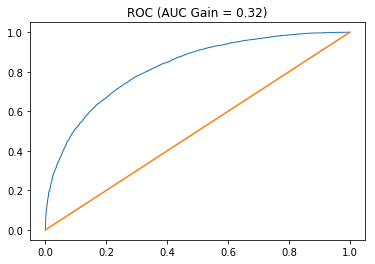

CPU times: user 344 ms, sys: 50 ms, total: 394 ms
Wall time: 364 ms
PRECISION/RECALL AUC


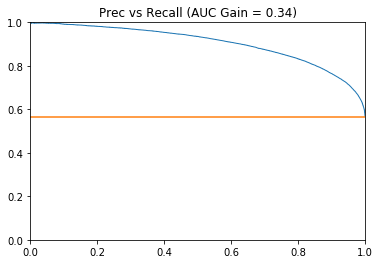

CPU times: user 534 ms, sys: 76.9 ms, total: 611 ms
Wall time: 539 ms


In [64]:
mlp = sklearn.neural_network.MLPClassifier()
%time mlp.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(mlp,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(mlp,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(mlp,X,y)

print("PRECISION/RECALL AUC")
%time prrc_auc(mlp,X,y)

# qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
# clf = qda
# %time clf.fit(X[tidx],y[tidx])

# print("TEST")
# %time evaluate(clf,X[pidx],y[pidx])

# print("TRAIN")
# %time evaluate(clf,X[tidx],y[tidx])

# # print("ROC AUC")
# # %time roc_auc(clf,X,y)

# # print("PRECISION/RECALL AUC")
# # %time prrc_auc(clf,X,y)

In [67]:
sent_pred = mlp.predict(tvecs_predict[:N])

np.mean(sent_pred)

0.076923076923076927

In [68]:
sent_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])